In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import numpy as np
import os
import datetime
%matplotlib inline

In [2]:
!unzip /content/drive/MyDrive/kvasir-dataset-v2.zip

Streaming output truncated to the last 5000 lines.
  inflating: kvasir-dataset-v2/normal-pylorus/79b990c2-870b-4cdd-8d8d-ad7ea33e0258.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/af744492-dc36-4f70-95e8-9056c462eaca.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/7f607ea9-1c1a-4e65-9888-7db35c807f59.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/c777b21e-9dc0-4179-a849-455044cb0d2c.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/9a824235-7dda-494b-8213-a1185ac7d7ab.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/b9559ef9-163d-4d98-a8d4-5f058bfa8003.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/3f429284-8727-43df-800a-6bfc84e71cc2.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/dabd496e-b1b0-4c25-aebb-a65a8fe4739c.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/5c1e245c-c69e-42e5-a5b3-fcfba78b667f.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/32b4ac97-2c27-4059-aa53-c304fdc2cc50.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/1d9233e5-05fb

In [3]:
img_path = "kvasir-dataset-v2"

batch_size=16
img_height = 128
img_width = 128


In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  img_path,
  seed=123,
  validation_split= 0.3,
  shuffle=True,
  subset="training" ,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8000 files belonging to 8 classes.
Using 5600 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  img_path,
  seed=123,
  validation_split= 0.3,
  shuffle=True,
  subset="validation" ,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8000 files belonging to 8 classes.
Using 2400 files for validation.


In [6]:
test_ds = val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  img_path,
  seed=123,
  validation_split= 0.1,
  shuffle=True,
  subset="validation" ,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8000 files belonging to 8 classes.
Using 800 files for validation.


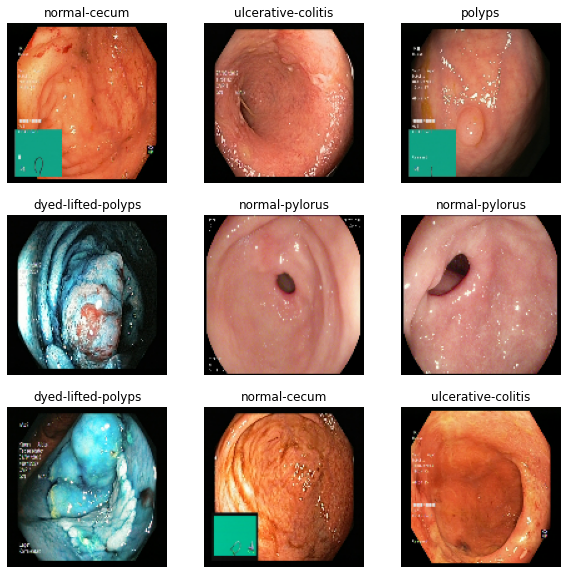

In [7]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
def conv_2d(filters, kernel_size=3):
    return Sequential([
        Conv2D(filters, kernel_size ,padding='SAME',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)), 
        #tf.keras.layers.BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,),
        #tf.keras.layers.ReLU(max_value=None, negative_slope=0, threshold=0)
        ]
    )

In [9]:
def triple_conv():
    return Sequential([
        conv_2d(32),
        conv_2d(32,2),  
        conv_2d(16,2)
    ]
    )

In [10]:
model = Sequential([
        layers.experimental.preprocessing.Rescaling(1./255),
        Conv2D(64, 3, activation='relu', name='conv_1', padding='SAME'),
        triple_conv(),
        MaxPooling2D(pool_size=(5, 5), name='pool_0'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu',padding='SAME', name='conv_2'),
        MaxPooling2D(pool_size=(5, 5), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=16, activation='relu', name='dense_1'),
        Dense(units=8, activation='softmax', name='dense_2')
    ])

In [11]:
def get_early_stopping():
    
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
def get_checkpoint_best_only():
    
    checkpoint_best_path= 'checkpoints_best_only'
    checkpoint_best= ModelCheckpoint(filepath=checkpoint_best_path,
                           frequency='epoch',
                           save_weights_only=False,
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    return checkpoint_best


In [12]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#callbacks = [checkpoint_best_only, early_stopping, tensorboard_callback]
callbacks = [checkpoint_best_only, tensorboard_callback]

In [13]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [14]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks)

Epoch 1/30
350/350 [==============================] - ETA: 0s - loss: 1.2748 - accuracy: 0.4977
Epoch 1: val_accuracy improved from -inf to 0.62000, saving model to checkpoints_best_only
INFO:tensorflow:Assets written to: checkpoints_best_only/assets
350/350 [==============================] - 73s 170ms/step - loss: 1.2748 - accuracy: 0.4977 - val_loss: 0.8828 - val_accuracy: 0.6200
Epoch 2/30
350/350 [==============================] - ETA: 0s - loss: 0.8305 - accuracy: 0.6459
Epoch 2: val_accuracy improved from 0.62000 to 0.71250, saving model to checkpoints_best_only
INFO:tensorflow:Assets written to: checkpoints_best_only/assets
350/350 [==============================] - 55s 154ms/step - loss: 0.8305 - accuracy: 0.6459 - val_loss: 0.7268 - val_accuracy: 0.7125
Epoch 3/30
350/350 [==============================] - ETA: 0s - loss: 0.7473 - accuracy: 0.6825
Epoch 3: val_accuracy did not improve from 0.71250
350/350 [==============================] - 49s 139ms/step - loss: 0.7473 - accur

In [15]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv_1 (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 sequential_3 (Sequential)   (None, 128, 128, 16)      24656     
                                                                 
 pool_0 (MaxPooling2D)       (None, 25, 25, 16)        0         
                                                                 
 conv_2 (Conv2D)             (None, 25, 25, 8)         1160      
                                                                 
 pool_1 (MaxPooling2D)       (None, 5, 5, 8)           0         
                                                                 
 flatten (Flatten)           (None, 200)              

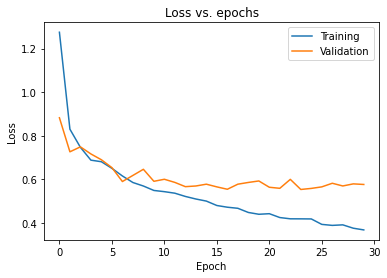

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

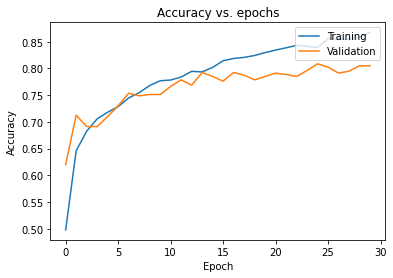

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [18]:
from IPython.display import Image, display
import matplotlib.cm as cm

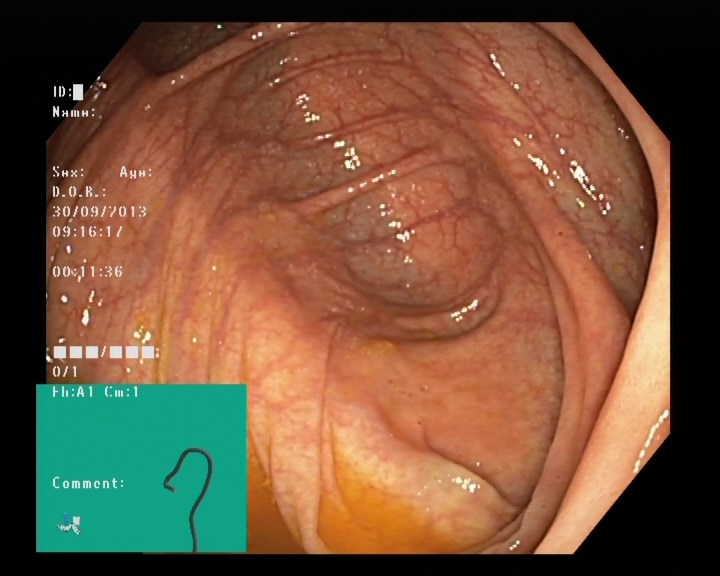

In [19]:
img_size = (128, 128)


last_conv_layer_name = "conv_2"

# The local path to our target image
img_path = "/content/kvasir-dataset-v2/normal-cecum/0111fb06-3113-4abf-9050-7bfb8d4688f5.jpg"

display(Image(img_path))

In [20]:
def get_img_array(img_path, size):
    
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

[[0.04626482 0.02732509 0.20276342 0.01431863 0.15725675 0.29329723
  0.23720741 0.02156662]]


<function matplotlib.pyplot.show>

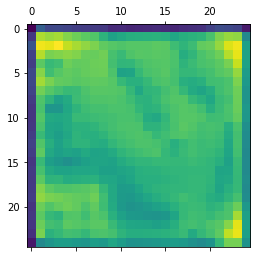

In [21]:
preprocess_input = keras.applications.xception.preprocess_input

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))


# Print what the top predicted class is
preds = model.predict(img_array)
print(preds)


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show

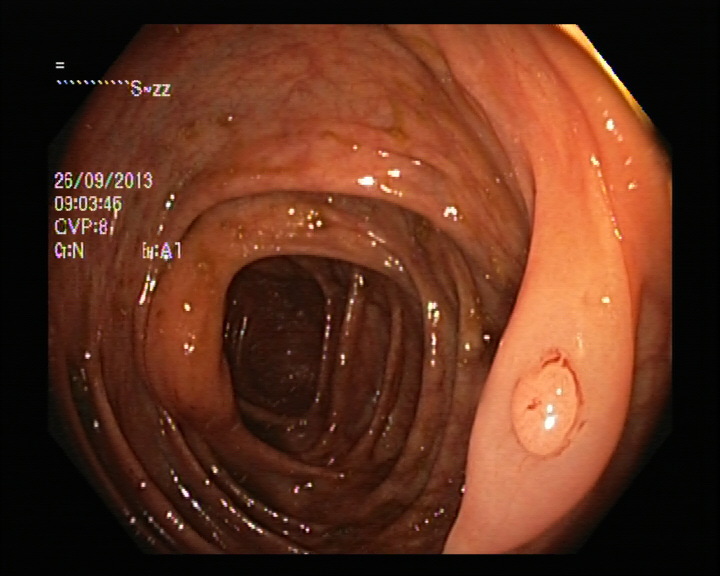

In [22]:
img_path = "/content/kvasir-dataset-v2/polyps/01a72489-11c2-4891-a2b8-7a0fb1181b7c.jpg"

display(Image(img_path))

[[0.04660456 0.0261094  0.2059533  0.01396901 0.14291367 0.30686304
  0.23746401 0.02012301]]


<function matplotlib.pyplot.show>

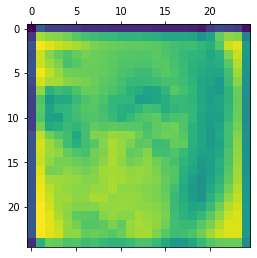

In [23]:
preprocess_input = keras.applications.xception.preprocess_input

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))


# Print what the top predicted class is
preds = model.predict(img_array)
print(preds)


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show

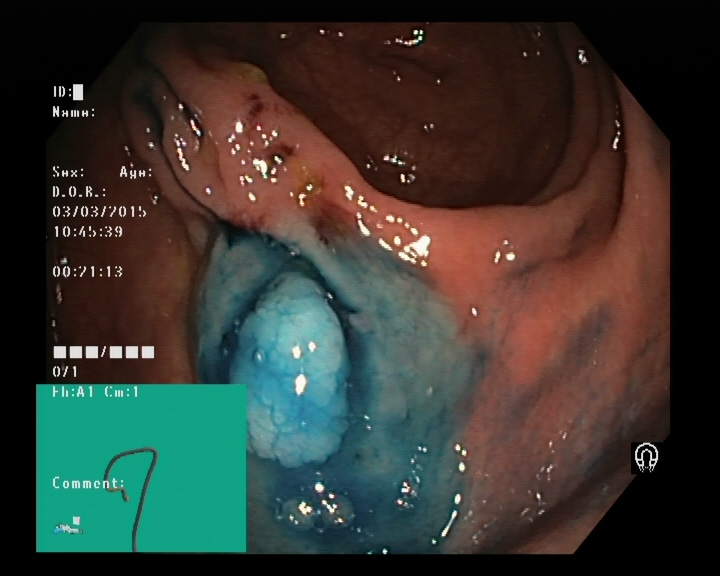

In [24]:
img_path = "/content/kvasir-dataset-v2/dyed-lifted-polyps/01507fbd-4d38-4525-9768-7754710f507c.jpg"

display(Image(img_path))

[[0.04579747 0.02590225 0.2064525  0.01391658 0.14171715 0.31228727
  0.23446248 0.01946423]]


<function matplotlib.pyplot.show>

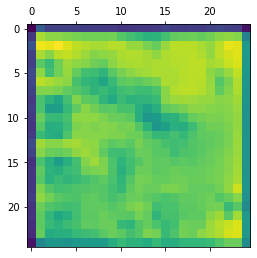

In [25]:
preprocess_input = keras.applications.xception.preprocess_input

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))


# Print what the top predicted class is
preds = model.predict(img_array)
print(preds)


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show

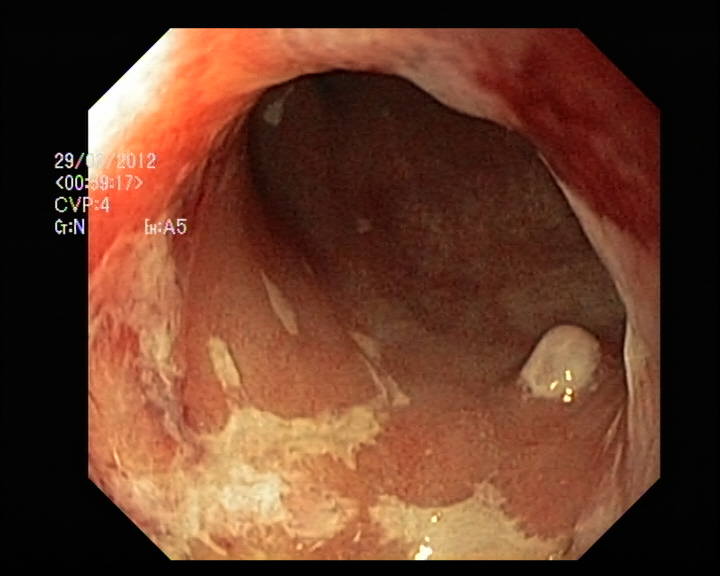

In [26]:
img_path = "/content/kvasir-dataset-v2/ulcerative-colitis/02daad2b-534a-4822-96ab-0d42d23a3fb9.jpg"

display(Image(img_path))

[[0.04704905 0.0271618  0.19920371 0.01422551 0.15331727 0.2965612
  0.24097693 0.02150458]]


<function matplotlib.pyplot.show>

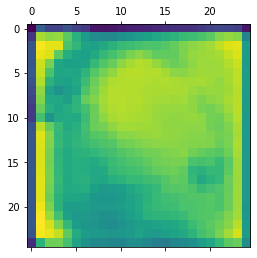

In [27]:
preprocess_input = keras.applications.xception.preprocess_input

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))


# Print what the top predicted class is
preds = model.predict(img_array)
print(preds)


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show

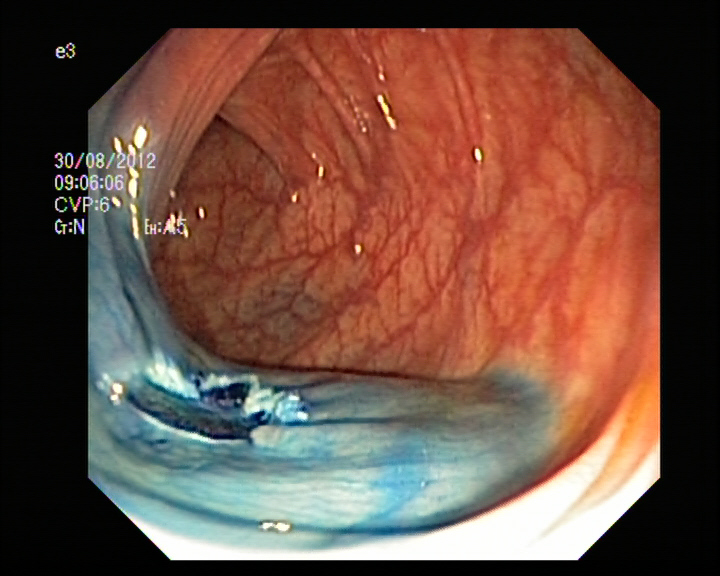

In [28]:
img_path = "/content/kvasir-dataset-v2/dyed-resection-margins/0bd00d23-3970-4965-87dc-29526ff5080b.jpg"

display(Image(img_path))

[[0.04548755 0.0268631  0.20225947 0.01387936 0.15790148 0.29400745
  0.23825254 0.02134911]]


<function matplotlib.pyplot.show>

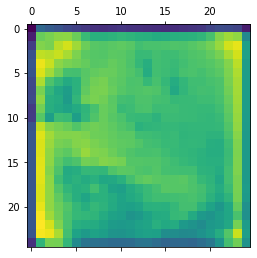

In [29]:
preprocess_input = keras.applications.xception.preprocess_input

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))


# Print what the top predicted class is
preds = model.predict(img_array)
print(preds)


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show